In [2]:
import torch
import numpy as np
import os
from torchvision.io import read_image
import os
import matplotlib.pyplot as plt
import scipy.io
import h5py
import cv2

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
ROOT = '/work3/s212645/Spectral_Reconstruction'

TRAIN_RGB = '/Train_RGB/'
TRAIN_SP = '/Valid_Spec/'


In [5]:
names = []
for path, dirs, files in os.walk(ROOT+TRAIN_SP):
    for file in files:
        num_video = os.path.basename(path)
        names.append(os.path.basename(os.path.dirname(path)))
        hyper_path = os.path.join(path,file)
        with h5py.File(hyper_path, 'r') as mat:
            hyper =np.float32(np.array(mat['cube']))
        hyper = np.transpose(hyper, [0, 2, 1])
        if hyper.any() == 0:
            print(file)

(128, 128, 3)


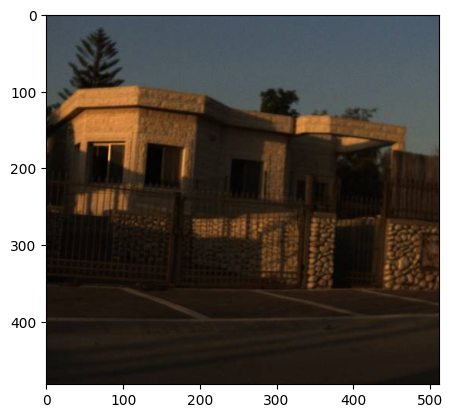

In [4]:
names = []
for path, dirs, files in os.walk(ROOT+TRAIN_RGB):
    for file in files:
        num_video = os.path.basename(path)
        names.append(os.path.basename(os.path.dirname(path)))
        hyper_path = os.path.join(path,file)
        bgr_path = os.path.join(path,file)
        bgr = cv2.imread(bgr_path)
        bgr2rgb = True
        if bgr2rgb:
            bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        bgr = np.float32(bgr)
        bgr = (bgr-bgr.min())/(bgr.max()-bgr.min())
        bgr = np.transpose(bgr, [2, 0, 1])  # [3,482,512]
        
        stride = 8
        crop_size = 128
        idx = 0
        
        h,w = 482,512  # img shape
        patch_per_line = (w-crop_size)//stride+1
        patch_per_colum = (h-crop_size)//stride+1
        patch_per_img = patch_per_line*patch_per_colum
        img_idx, patch_idx = idx//patch_per_img, idx%patch_per_img
        h_idx, w_idx = patch_idx//patch_per_line, patch_idx%patch_per_line
        img = bgr[:,h_idx*stride:h_idx*stride+crop_size, w_idx*stride:w_idx*stride+crop_size]
        
        img = img.transpose(1,2,0)
        print(img.shape)
        plt.imshow(bgr.transpose(1,2,0))
        
        break

In [12]:
outputs = torch.randn([64,31,128,128])
label = torch.randn_like(outputs)
error = torch.abs(outputs.view(-1) - label.view(-1)) / label.view(-1)
# mrae = torch.mean(error.reshape(-1))
mrae = torch.mean(error.view(-1))
mrae
a = np.array([0,1,1])
print(a.all())

False


1.52587890625e-05

In [12]:
import torch.nn.functional as F
recons = torch.randn(1, 31, 128, 128)
input = torch.randn_like(recons)
mu = torch.randn(1, 1024)
log_var = torch.randn_like(mu)

kld_weight = 1024 / 128 / 128 / 31 # Account for the minibatch samples from the dataset
recons_loss =F.mse_loss(recons, input)

kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
print(recons_loss, kld_loss * kld_weight) 

tensor(1.9949) tensor(1.7568)


In [8]:
8/15

0.5333333333333333